# Downloading Gutenberg Corpus

In [ ]:
!pip install gdown --quiet

#download analogy sentences dataset - 50 with val words
!gdown 17T75JSOSK07S9M28TGQmOA5wAhJFzXa4

Downloading...
From: https://drive.google.com/uc?id=17T75JSOSK07S9M28TGQmOA5wAhJFzXa4
To: /kaggle/working/Analogy_sentences_50.txt
100%|███████████████████████████████████████| 2.35M/2.35M [00:00<00:00, 172MB/s]


In [ ]:
import nltk
import numpy as np
import torch
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package gutenberg to /usr/share/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from pickle import load, dump

In [ ]:
import os
import shutil

In [ ]:
src_dir = '/kaggle/working/books'
des_dir ='/usr/share/nltk_data/corpora/gutenberg'


In [ ]:
shutil.copyfile("/kaggle/working/Analogy_sentences_50.txt",os.path.join(des_dir, "analogy_50.txt"))

'/usr/share/nltk_data/corpora/gutenberg/analogy_50.txt'

In [ ]:
print(len(os.listdir(des_dir)))

20


# Gutenberg corpus Train Sample Preparation

In [ ]:
from nltk.corpus import gutenberg, stopwords
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm

## SkipGram

In [ ]:
!pip install ordered_set

In [ ]:
from ordered_set import OrderedSet

In [ ]:
guten_file_list = sorted([i for i in os.listdir(des_dir) if '.txt' in i])
print(len(guten_file_list))
print(guten_file_list)

19
['analogy_50.txt', 'austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [ ]:
# tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stopwords_in_validation = ['most', 'his', 'she', 'her', 'he']
for sw in stopwords_in_validation:
    stop_words.remove(sw)

def mapping(tokens):
    word_to_id = {}
    id_to_word = {}

    for i, token in enumerate(tokens):
        word_to_id[token] = i
        id_to_word[i] = token

    return word_to_id, id_to_word

def get_train_data(file_list, window, skipgram=True):
  vocab = []
  X = []
  Y = []

  for single_file in tqdm(file_list):
    sentences = gutenberg.sents(single_file)
    for sentence in sentences:
      clean_sentence = [word.lower() for word in sentence if word.isascii() and word.isalpha() and word.lower() not in stop_words]
      vocab.extend(clean_sentence)
      x = []
      for idx in range(len(clean_sentence)-2*window-1):
        y = []
        sample = clean_sentence[idx : idx + 2*window+1]
        x = sample[window]
        for num in range(2*window+1):
          if num != window:
            y.append(sample[num])

        X.append(x)
        Y.append([y])

  #clean dataset
  #remove duplicate ordered pairs
#   dataset = tuple(zip(X, Y))
#   final_dataset = list(set(dataset))

#   X = [data[0] for data in final_dataset]
#   Y = [data[1] for data in final_dataset]

  #unique vocab words - need to maintain the order
  final_vocab = list(OrderedSet(vocab))
  word_to_id, id_to_word = mapping(final_vocab)

  if skipgram:
    return X, Y, word_to_id, id_to_word
  else:
    return Y, X, word_to_id, id_to_word

In [ ]:
window = 5

X, Y, word_to_id, id_to_word = get_train_data(guten_file_list, window, skipgram=True)

100%|██████████| 19/19 [00:09<00:00,  1.90it/s]


In [ ]:
#saved pickled files
with open(r'/kaggle/input/w2id-id2w/new_id2w.pkl', 'rb') as f:
    id_to_word = load(f)

with open(r'/kaggle/input/w2id-id2w/new_w2id.pkl', 'rb') as f:
    word_to_id = load(f)

In [ ]:
len(X), len(Y), len(word_to_id)

(429040, 429040, 51608)

In [ ]:
# with open(r'new_w2id.pkl', 'wb') as f:
#   dump(word_to_id, f)

553


In [ ]:
# with open(r'new_id2w.pkl', 'wb') as f:
#   dump(id_to_word, f)

In [ ]:
def one_hot_batch_encoding(batch, word_to_id, x_comes=True):
    B = torch.zeros((len(batch), len(word_to_id)))           #B_dim = bXV; batch_dim = [batch_size, 0]
    if x_comes:
        for i, w in enumerate(batch):
            B[i, word_to_id[w]] = 1.0

    else:
        for i, words in enumerate(batch):
            for w in words[0]:
                B[i, word_to_id[w]] = 1.0/len(words[0])

    return B.to('cuda')


In [ ]:
class DataLoader:
  def __init__(self, word_to_id, id_to_word, X, Y, one_hot_encoding, batch_size):
    self.word_to_id = word_to_id
    self.id_to_word = id_to_word
    self.X = X
    self.Y = Y
    self.batch_size = batch_size
    self.batch_idx = 0
    self.max_length = len(X)
    self.one_hot_encoding = one_hot_encoding
  def __iter__(self):
    return self
  def __next__(self):
    curr_batch_idx = self.batch_idx
    self.batch_idx = self.batch_idx + self.batch_size
    if self.batch_idx < self.max_length:
      return self.one_hot_encoding(X[curr_batch_idx:self.batch_idx], self.word_to_id), self.one_hot_encoding(Y[curr_batch_idx:self.batch_idx], self.word_to_id, x_comes=False)
    self.batch_idx = 0
    raise StopIteration
  def __len__(self):
    return len(self.X)//self.batch_size

In [ ]:
# loader = DataLoader(word_to_id, id_to_word, X, Y, one_hot_batch_encoding, batch_size = 1024)
loader = DataLoader(word_to_id, id_to_word, X, Y, one_hot_batch_encoding, batch_size = 1000)

In [ ]:
def softmax(batch, epsilon = 1e-5):

  num = batch - torch.amax(batch, dim = 1, keepdim=True)
  num = torch.exp(num)
  den = torch.sum(num, axis=1).reshape((-1,1)) + epsilon
  return num/den

def cross_entropy(y_pred, y_true, epsilon = 1e-5):
  return -torch.mean(torch.sum(y_true * torch.log(y_pred + epsilon),axis=1))

def tss(y_pred, y_true):
  return 0.5*torch.sum((y_pred - y_true)**2)

class word2vec:

  def __init__(self, vocab_size, embedding_size, output_activation, loss_fn):
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    he_in = np.sqrt(6/vocab_size)
    he_hidden = np.sqrt(6/embedding_size)
    self.network = {
        # "w1" : torch.randn(self.vocab_size, self.embedding_size).to("cuda"),
        # "w2" : torch.randn(self.embedding_size, self.vocab_size).to("cuda")
        "w1" : (2*he_in*torch.rand(self.vocab_size, self.embedding_size) - he_in).to("cuda"),
        "w2" : (2*he_hidden*torch.rand(self.embedding_size, self.vocab_size) - he_hidden).to("cuda")
    }
    self.output_activation = output_activation
    self.loss_fn = loss_fn

    self.mW1 = 0
    self.mV1 = 0
    self.mW2 = 0
    self.mV2 = 0

  def forward(self, X):
    cache = {}
    cache["a1"] = X @ self.network["w1"]
    cache["a2"] = cache["a1"] @ self.network["w2"]
    cache["z"] = self.output_activation(cache["a2"])
    return cache

  def predict(self, X):
    return self.output_activation((X@self.network["w1"])@self.network["w2"])

  def backward(self, cache, x, y, alpha, epoch, beta1 = 0.9, beta2 = 0.99, epsilon=1e-5):
      # cache  = self.forward(x)
      M = x.shape[0]
      obs = cache["z"]
      da2 = obs - y
      dw2 = (cache["a1"].T @ da2)/M      #softmax derivative added
      da1 = da2 @ self.network["w2"].T
      dw1 = (x.T @ da1)/M

      #ADAM optimization step for w1
      self.mW1 = beta1*self.mW1 + (1-beta1)*dw1
      self.mV1 = beta2*self.mV1 + (1-beta2)*(dw1**2)
      mW1_hat = self.mW1/(1-beta1**epoch)
      mV1_hat = self.mV1/(1-beta2**epoch)
      dw1 = mW1_hat/(torch.sqrt(mV1_hat) + epsilon)

      #ADAM optimization step for w2
      self.mW2 = beta1*self.mW2 + (1-beta1)*dw2         #momentum with 1st moment
      self.mV2 = beta2*self.mV2 + (1-beta2)*(dw2**2)    #momentum with second moment
      mW2_hat = self.mW2/(1-beta1**epoch)               #bias correction
      mV2_hat = self.mV2/(1-beta2**epoch)
      dw2 = mW2_hat/(torch.sqrt(mV2_hat) + epsilon)     #final computation -> RMSProp

      assert(dw2.shape == self.network["w2"].shape)
      assert(dw1.shape == self.network["w1"].shape)
      self.network["w1"] -= alpha * dw1            #over M batches
      self.network["w2"] -= alpha * dw2

      #calculate loss after adjusting weights
      cache_after_train = self.forward(x)
      loss = self.loss_fn(cache_after_train["z"], y)
      # if torch.isnan(loss):
      #   print(x.T, dw1, da1, self.network['w1'],self.network['w2'],cache["z"])
      return loss

In [ ]:
model = word2vec(len(word_to_id), embedding_size = 50, output_activation = softmax, loss_fn = cross_entropy)

In [ ]:
epochs = 100

lavg = []

beta1 = 0.9
beta2 = 0.999
alpha = 1e-3

for epoch in range(epochs):
  with tqdm(total=len(loader)) as progress_bar:
    L = []
    for x,y in loader:
      x = x.to("cuda")
      y = y.to("cuda")
      cache = model.forward(x)
      loss = model.backward(cache, x, y, alpha = alpha, beta1=beta1, beta2=beta2, epoch=epoch+1)
      if torch.isnan(loss):
        break
      L.append(loss.cpu().item())
      progress_bar.update(1)
      progress_bar.set_description(f"Loss : {loss}")
      progress_bar.refresh()
    lavg.append(np.mean(L))
    if len(lavg)>=2 and lavg[-1]>lavg[-2]:
      print("Loss rising. Stopped!")
      break
  print(f"Epoch : {epoch}")

Loss : 9.689728736877441:  79%|███████▊  | 337/429 [02:27<00:40,  2.29it/s]


Epoch : 0


Loss : 9.326870918273926: 100%|██████████| 429/429 [03:07<00:00,  2.28it/s] 


Epoch : 1


Loss : 9.179558753967285: 100%|██████████| 429/429 [03:10<00:00,  2.26it/s] 


Epoch : 2


Loss : 9.092963218688965: 100%|██████████| 429/429 [03:09<00:00,  2.26it/s] 


Epoch : 3


Loss : 9.033586502075195: 100%|██████████| 429/429 [03:09<00:00,  2.27it/s] 


Epoch : 4


Loss : 8.989238739013672: 100%|██████████| 429/429 [03:08<00:00,  2.27it/s] 


Epoch : 5


Loss : 8.954252243041992: 100%|██████████| 429/429 [03:09<00:00,  2.26it/s] 


Epoch : 6


Loss : 8.925578117370605: 100%|██████████| 429/429 [03:09<00:00,  2.26it/s] 


Epoch : 7


Loss : 8.901426315307617: 100%|██████████| 429/429 [03:09<00:00,  2.27it/s] 


Epoch : 8


Loss : 8.880668640136719: 100%|██████████| 429/429 [03:10<00:00,  2.26it/s] 


Epoch : 9


Loss : 8.862550735473633: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 10


Loss : 8.84654712677002: 100%|██████████| 429/429 [03:10<00:00,  2.26it/s]  


Epoch : 11


Loss : 8.832266807556152: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 12


Loss : 8.819409370422363: 100%|██████████| 429/429 [03:10<00:00,  2.26it/s] 


Epoch : 13


Loss : 8.807743072509766: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 14


Loss : 8.797077178955078: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 15


Loss : 8.787261962890625: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 16


Loss : 8.77817153930664: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s]  


Epoch : 17


Loss : 8.769701957702637: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 18


Loss : 8.761764526367188: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 19


Loss : 8.754284858703613: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 20


Loss : 8.747198104858398: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 21


Loss : 8.740448951721191: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 22


Loss : 8.733986854553223: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 23


Loss : 8.727766036987305: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 24


Loss : 8.721750259399414: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 25


Loss : 8.715909004211426: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 26


Loss : 8.710214614868164: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 27


Loss : 8.704648971557617: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 28


Loss : 8.699197769165039: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 29


Loss : 8.69385814666748: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s]  


Epoch : 30


Loss : 8.68862247467041: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s]  


Epoch : 31


Loss : 8.683493614196777: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 32


Loss : 8.678465843200684: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 33


Loss : 8.673537254333496: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 34


Loss : 8.668699264526367: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 35


Loss : 8.663938522338867: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 36


Loss : 8.65924072265625: 100%|██████████| 429/429 [03:11<00:00,  2.25it/s]  


Epoch : 37


Loss : 8.65458869934082: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s]  


Epoch : 38


Loss : 8.64996337890625: 100%|██████████| 429/429 [03:11<00:00,  2.25it/s]  


Epoch : 39


Loss : 8.645346641540527: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 40


Loss : 8.640727996826172: 100%|██████████| 429/429 [03:11<00:00,  2.25it/s] 


Epoch : 41


Loss : 8.636090278625488: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 42


Loss : 8.631427764892578: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 43


Loss : 8.626731872558594: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 44


Loss : 8.62199878692627: 100%|██████████| 429/429 [03:11<00:00,  2.25it/s]  


Epoch : 45


Loss : 8.617223739624023: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 46


Loss : 8.612407684326172: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 47


Loss : 8.607547760009766: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 48


Loss : 8.602643013000488: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 49


Loss : 8.597697257995605: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 50


Loss : 8.592708587646484: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 51


Loss : 8.587679862976074: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 52


Loss : 8.582611083984375: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 53


Loss : 8.577503204345703: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 54


Loss : 8.572360038757324: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 55


Loss : 8.567177772521973: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 56


Loss : 8.561963081359863: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 57


Loss : 8.55671501159668: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s]  


Epoch : 58


Loss : 8.551433563232422: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 59


Loss : 8.546122550964355: 100%|██████████| 429/429 [03:13<00:00,  2.22it/s] 


Epoch : 60


Loss : 8.540780067443848: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 61


Loss : 8.535407066345215: 100%|██████████| 429/429 [03:13<00:00,  2.22it/s] 


Epoch : 62


Loss : 8.530003547668457: 100%|██████████| 429/429 [03:12<00:00,  2.22it/s] 


Epoch : 63


Loss : 8.524569511413574: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 64


Loss : 8.519105911254883: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 65


Loss : 8.513608932495117: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 66


Loss : 8.508081436157227: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 67


Loss : 8.502517700195312: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 68


Loss : 8.496922492980957: 100%|██████████| 429/429 [03:11<00:00,  2.25it/s] 


Epoch : 69


Loss : 8.491291999816895: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 70


Loss : 8.485625267028809: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 71


Loss : 8.479923248291016: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 72


Loss : 8.474184036254883: 100%|██████████| 429/429 [03:11<00:00,  2.25it/s] 


Epoch : 73


Loss : 8.46841049194336: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s]  


Epoch : 74


Loss : 8.462597846984863: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 75


Loss : 8.456748008728027: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 76


Loss : 8.450861930847168: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 77


Loss : 8.444937705993652: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 78


Loss : 8.438977241516113: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 79


Loss : 8.432976722717285: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 80


Loss : 8.426939964294434: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 81


Loss : 8.420866012573242: 100%|██████████| 429/429 [03:11<00:00,  2.25it/s] 


Epoch : 82


Loss : 8.414753913879395: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 83


Loss : 8.408604621887207: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 84


Loss : 8.402419090270996: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 85


Loss : 8.396197319030762: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 86


Loss : 8.389942169189453: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 87


Loss : 8.383652687072754: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 88


Loss : 8.377330780029297: 100%|██████████| 429/429 [03:10<00:00,  2.26it/s] 


Epoch : 89


Loss : 8.370976448059082: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 90


Loss : 8.364592552185059: 100%|██████████| 429/429 [03:10<00:00,  2.26it/s] 


Epoch : 91


Loss : 8.358180046081543: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 92


Loss : 8.351738929748535: 100%|██████████| 429/429 [03:09<00:00,  2.26it/s] 


Epoch : 93


Loss : 8.345272064208984: 100%|██████████| 429/429 [03:10<00:00,  2.26it/s] 


Epoch : 94


Loss : 8.338777542114258: 100%|██████████| 429/429 [03:09<00:00,  2.27it/s] 


Epoch : 95


Loss : 8.332259178161621: 100%|██████████| 429/429 [03:09<00:00,  2.26it/s] 


Epoch : 96


Loss : 8.325714111328125: 100%|██████████| 429/429 [03:09<00:00,  2.26it/s] 


Epoch : 97


Loss : 8.31914234161377: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s]  


Epoch : 98


Loss : 8.312542915344238: 100%|██████████| 429/429 [03:10<00:00,  2.26it/s] 

Epoch : 99


In [ ]:
print(lavg)

[9.553101050040135, 8.827281841864952, 8.521595112371555, 8.376583262756988, 8.286243036354616, 8.222836726751083, 8.175031566397571, 8.137167051399782, 8.106066255858451, 8.079804324881458, 8.057145383252408, 8.037254941491257, 8.019542380646392, 8.003571618131268, 7.989008408882123, 7.9755887818503215, 7.963099450776071, 7.951365231911897, 7.940241222337131, 7.929606747793985, 7.919361873662277, 7.909423512456578, 7.899723057424549, 7.890203965015901, 7.880819295114015, 7.8715303505495156, 7.862304824215549, 7.853115992112593, 7.843941958634169, 7.834765823293122, 7.825575545117571, 7.816364326121368, 7.807130949202673, 7.797879635870873, 7.788619437139907, 7.77936390229872, 7.770129316058748, 7.7609329179172475, 7.751790763614895, 7.742715970063821, 7.73371782502928, 7.724801670421254, 7.715969025671899, 7.707218275759326, 7.698545441483006, 7.689945137584126, 7.681411070701404, 7.672936446183211, 7.664514512726755, 7.656138885827054, 7.6478037923088165, 7.639504161470142, 7.6312358

In [ ]:
SkipGram = model.network
SkipGram['w1'] = model.network['w1'].cpu().detach().numpy()
SkipGram['w2'] = model.network['w2'].cpu().detach().numpy()

with open('SkipGram.pkl', 'wb') as f:
  dump(SkipGram, f)

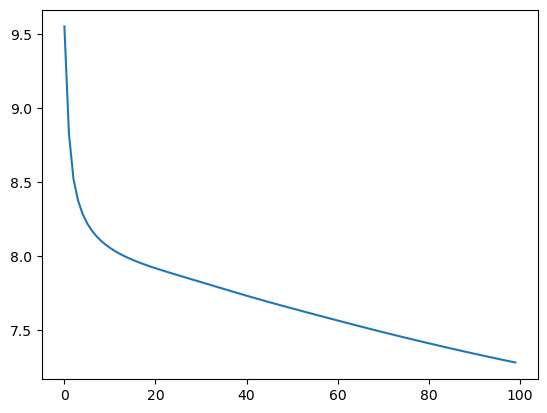

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lavg)

In [ ]:
plt.savefig('Skipgram_loss.jpg')

<Figure size 640x480 with 0 Axes>

## CBOW

In [ ]:
def one_hot_batch_encoding_cbow(batch, word_to_id, x_comes=True):
  B = torch.zeros((len(batch), len(word_to_id)))           #B_dim = bXV; batch_dim = [batch_size, 0]

  if x_comes==False:
    for i,w in enumerate(batch):
      B[i, word_to_id[w]] = 1
  else:
    for i,words in enumerate(batch):
#       print('words=', words)
      for w in words:
        B[i, word_to_id[w]] = 1/len(words)

  return B.to('cuda')

In [ ]:
cbow_loader = DataLoader(word_to_id, id_to_word, Y, X, one_hot_batch_encoding, batch_size = 1000)

# model_cbow = word2vec(len(word_to_id), embedding_size = 100, output_activation = softmax, loss_fn = cross_entropy)

In [ ]:
model_cbow = word2vec(len(word_to_id), embedding_size = 50, output_activation = softmax, loss_fn = cross_entropy)

In [ ]:
epochs = 100

beta1 = 0.9
beta2 = 0.999
alpha = 1e-3
lavg_cbow = []

for epoch in range(epochs):
  with tqdm(total=len(cbow_loader)) as progress_bar:
    L = []
    for x,y in cbow_loader:
      x = x.to("cuda")
      y = y.to("cuda")
      cache = model_cbow.forward(x)
      loss = model_cbow.backward(cache, x, y, alpha = alpha, beta1 = beta1, beta2 = beta2, epoch = epoch+1)
      if torch.isnan(loss):
        exit()
      L.append(loss.cpu().item())

      progress_bar.update(1)
      progress_bar.set_description(f"Loss : {loss}")
      progress_bar.refresh()
  lavg_cbow.append(np.mean(L))
  #adding stopping condition if loss over epoch goes up
  if len(lavg_cbow)>=2 and lavg_cbow[-1]>lavg_cbow[-2]:
      print("Loss rising. Stopped!")
      exit()

  print(f"Epoch : {epoch}")

Loss : 9.694146156311035: 100%|██████████| 429/429 [03:08<00:00,  2.27it/s] 


Epoch : 0


Loss : 9.325822830200195: 100%|██████████| 429/429 [03:09<00:00,  2.26it/s] 


Epoch : 1


Loss : 9.17835521697998: 100%|██████████| 429/429 [03:11<00:00,  2.25it/s]  


Epoch : 2


Loss : 9.092100143432617: 100%|██████████| 429/429 [03:09<00:00,  2.26it/s] 


Epoch : 3


Loss : 9.032907485961914: 100%|██████████| 429/429 [03:10<00:00,  2.26it/s] 


Epoch : 4


Loss : 8.98856258392334: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s]  


Epoch : 5


Loss : 8.953463554382324: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 6


Loss : 8.9246187210083: 100%|██████████| 429/429 [03:10<00:00,  2.26it/s]   


Epoch : 7


Loss : 8.900275230407715: 100%|██████████| 429/429 [03:09<00:00,  2.26it/s] 


Epoch : 8


Loss : 8.87932014465332: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s]  


Epoch : 9


Loss : 8.861011505126953: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 10


Loss : 8.844820976257324: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 11


Loss : 8.83035659790039: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s]  


Epoch : 12


Loss : 8.8173189163208: 100%|██████████| 429/429 [03:10<00:00,  2.26it/s]   


Epoch : 13


Loss : 8.805471420288086: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 14


Loss : 8.794621467590332: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 15


Loss : 8.784618377685547: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 16


Loss : 8.775336265563965: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 17


Loss : 8.76667308807373: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s]  


Epoch : 18


Loss : 8.758541107177734: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 19


Loss : 8.750871658325195: 100%|██████████| 429/429 [03:13<00:00,  2.22it/s] 


Epoch : 20


Loss : 8.743603706359863: 100%|██████████| 429/429 [03:11<00:00,  2.25it/s] 


Epoch : 21


Loss : 8.73669147491455: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s]  


Epoch : 22


Loss : 8.73009204864502: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s]  


Epoch : 23


Loss : 8.723775863647461: 100%|██████████| 429/429 [03:10<00:00,  2.26it/s] 


Epoch : 24


Loss : 8.717717170715332: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 25


Loss : 8.711894989013672: 100%|██████████| 429/429 [03:10<00:00,  2.26it/s] 


Epoch : 26


Loss : 8.706293106079102: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 27


Loss : 8.700897216796875: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 28


Loss : 8.695684432983398: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 29


Loss : 8.690641403198242: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 30


Loss : 8.685744285583496: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 31


Loss : 8.68096923828125: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s]  


Epoch : 32


Loss : 8.676292419433594: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 33


Loss : 8.671686172485352: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 34


Loss : 8.667125701904297: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 35


Loss : 8.662590026855469: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 36


Loss : 8.658061981201172: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 37


Loss : 8.653523445129395: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 38


Loss : 8.64896297454834: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s]  


Epoch : 39


Loss : 8.644369125366211: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 40


Loss : 8.63973617553711: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s]  


Epoch : 41


Loss : 8.635055541992188: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 42


Loss : 8.630321502685547: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 43


Loss : 8.62553596496582: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s]  


Epoch : 44


Loss : 8.620691299438477: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 45


Loss : 8.615789413452148: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 46


Loss : 8.610830307006836: 100%|██████████| 429/429 [03:11<00:00,  2.25it/s] 


Epoch : 47


Loss : 8.605813026428223: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 48


Loss : 8.600738525390625: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 49


Loss : 8.595610618591309: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 50


Loss : 8.59043025970459: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s]  


Epoch : 51


Loss : 8.585195541381836: 100%|██████████| 429/429 [03:10<00:00,  2.25it/s] 


Epoch : 52


Loss : 8.579915046691895: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 53


Loss : 8.574589729309082: 100%|██████████| 429/429 [03:12<00:00,  2.22it/s] 


Epoch : 54


Loss : 8.569219589233398: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 55


Loss : 8.563809394836426: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 56


Loss : 8.558362007141113: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 57


Loss : 8.552879333496094: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 58


Loss : 8.54736328125: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s]     


Epoch : 59


Loss : 8.541815757751465: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 60


Loss : 8.536237716674805: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 61


Loss : 8.530630111694336: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 62


Loss : 8.524994850158691: 100%|██████████| 429/429 [03:13<00:00,  2.21it/s] 


Epoch : 63


Loss : 8.519328117370605: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 64


Loss : 8.513635635375977: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 65


Loss : 8.507912635803223: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 66


Loss : 8.502161026000977: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 67


Loss : 8.496378898620605: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 68


Loss : 8.490571022033691: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 69


Loss : 8.484731674194336: 100%|██████████| 429/429 [03:13<00:00,  2.22it/s] 


Epoch : 70


Loss : 8.478864669799805: 100%|██████████| 429/429 [03:12<00:00,  2.22it/s] 


Epoch : 71


Loss : 8.472967147827148: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 72


Loss : 8.467039108276367: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 73


Loss : 8.461081504821777: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 74


Loss : 8.455093383789062: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 75


Loss : 8.449073791503906: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 76


Loss : 8.443023681640625: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 77


Loss : 8.436942100524902: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 78


Loss : 8.430830001831055: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 79


Loss : 8.42468547821045: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s]  


Epoch : 80


Loss : 8.418510437011719: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 81


Loss : 8.412304878234863: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 82


Loss : 8.4060697555542: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s]   


Epoch : 83


Loss : 8.399805068969727: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 84


Loss : 8.393511772155762: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 85


Loss : 8.387191772460938: 100%|██████████| 429/429 [03:13<00:00,  2.21it/s] 


Epoch : 86


Loss : 8.380844116210938: 100%|██████████| 429/429 [03:15<00:00,  2.19it/s] 


Epoch : 87


Loss : 8.374470710754395: 100%|██████████| 429/429 [03:15<00:00,  2.20it/s] 


Epoch : 88


Loss : 8.368073463439941: 100%|██████████| 429/429 [03:13<00:00,  2.21it/s] 


Epoch : 89


Loss : 8.361653327941895: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 90


Loss : 8.355210304260254: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 91


Loss : 8.348746299743652: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 92


Loss : 8.34226131439209: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s]  


Epoch : 93


Loss : 8.335756301879883: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 94


Loss : 8.329230308532715: 100%|██████████| 429/429 [03:11<00:00,  2.23it/s] 


Epoch : 95


Loss : 8.322684288024902: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 


Epoch : 96


Loss : 8.316117286682129: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 97


Loss : 8.309531211853027: 100%|██████████| 429/429 [03:12<00:00,  2.23it/s] 


Epoch : 98


Loss : 8.302923202514648: 100%|██████████| 429/429 [03:11<00:00,  2.24it/s] 

Epoch : 99


In [ ]:
CBoW = model_cbow.network
CBoW['w1'] = model_cbow.network['w1'].cpu().detach().numpy()
CBoW['w2'] = model_cbow.network['w2'].cpu().detach().numpy()

with open('CBoW.pkl', 'wb') as f:
  dump(CBoW, f)

[9.665359623782285, 8.830298098095092, 8.521400572814585, 8.376198006120873, 8.286151415818221, 8.22297110924354, 8.17522266472414, 8.137269106778232, 8.105980099497975, 8.079469228402163, 8.056524795807881, 8.036324322084726, 8.018282061134462, 8.00196252836214, 7.987030300504956, 7.973219523618827, 7.960315250850224, 7.94814116693599, 7.936551675374136, 7.925426403125683, 7.9146664125936015, 7.904190735939221, 7.893934103158804, 7.88384527482075, 7.87388547261556, 7.86402656981995, 7.854249576310734, 7.844542819025356, 7.834900691514805, 7.82532202447211, 7.815809295449779, 7.806367257258275, 7.797001760878485, 7.787718809567965, 7.778523791920055, 7.7694206771317065, 7.760411824935522, 7.7514975265467365, 7.7426759324151595, 7.73394350460915, 7.725295020150138, 7.71672409675616, 7.708223709693322, 7.699786514113277, 7.691405069577944, 7.683072112379096, 7.674780805627782, 7.666524924876251, 7.658298810323079, 7.6500974157195545, 7.641916508441205, 7.633752534995268, 7.62560256655677

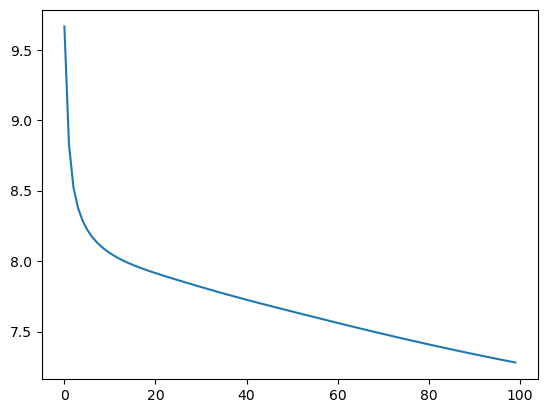

In [ ]:
print(lavg_cbow)
plt.plot(lavg_cbow)

In [ ]:
plt.savefig('CBoW_loss.jpg')

<Figure size 640x480 with 0 Axes>

## Testing

In [ ]:
matrix = model.network['w1']

word1 = "dull"
word2 = 'intelligent'
word3 = 'clever'

e1 = one_hot_batch_encoding([word1], word_to_id) @ matrix
e2 = one_hot_batch_encoding([word2], word_to_id) @ matrix
e3 = one_hot_batch_encoding([word3], word_to_id) @ matrix
e1@e2.T, e2@e3.T, e1@e3.T